In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Cài đặt thư viện + Import và xử lý dữ liệu

In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Đọc dữ liệu từ Google Drive
df = pd.read_csv("/content/drive/MyDrive/IS403/DoAnCuoiKy/Dataset/VIX_Cleaned.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Tạo các đặc trưng đầu vào và mục tiêu
features = ['Open', 'High', 'Low', 'Volume']
target = 'Close'
X = df[features]
y = df[target]
dates = df['Date']

df = df.set_index('Date')  # Đảm bảo 'Date' là chỉ mục thời gian
df = df.dropna()

# Lưu trữ ngày cho trực quan hóa
dates = df.index

# Normalize tất cả biến
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Chia tập train / val / test

In [3]:
def split_data(df, train_ratio, val_ratio, test_ratio):
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)
    return df.iloc[:train_end], df.iloc[train_end:val_end], df.iloc[val_end:], dates[:train_end], dates[train_end:val_end], dates[val_end:]

# Huấn luyện và đánh giá VAR

In [4]:
def train_evaluate_var(train_ratio, val_ratio, test_ratio, maxlags=15):
    print("="*60)
    print(f"Tỷ lệ: Train {int(train_ratio*100)}% - Val {int(val_ratio*100)}% - Test {int(test_ratio*100)}%")

    train, val, test, date_train, date_val, date_test = split_data(data_scaled, train_ratio, val_ratio, test_ratio)

    model = VAR(train)
    selected_lags = model.select_order(maxlags)
    best_lag = selected_lags.aic
    results = model.fit(best_lag)

    print(f"→ Best lag (AIC): {best_lag}")

    def forecast_and_evaluate(data_input, steps, actual_data, scaler):
        forecast = results.forecast(y=data_input.values[-best_lag:], steps=steps)
        forecast_df = pd.DataFrame(forecast, columns=df.columns, index=actual_data.index)

        # Inverse scaling
        actual_unscaled = scaler.inverse_transform(actual_data)
        pred_unscaled = scaler.inverse_transform(forecast_df)

        evals = {}
        for i, col in enumerate(df.columns):
            y_true = actual_unscaled[:, i]
            y_pred = pred_unscaled[:, i]

            mae = mean_absolute_error(y_true, y_pred)
            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_true, y_pred)
            # Tính MAPE, tránh chia cho 0 bằng np.where
            mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true != 0, y_true, np.nan))) * 100

            evals[col] = (mae, mse, rmse, mape, r2)

        return forecast_df, actual_unscaled, pred_unscaled, evals

    y_pred_val, yv, ypv, val_scores = forecast_and_evaluate(train, len(val), val, scaler)
    y_pred_test, yt, ypt, test_scores = forecast_and_evaluate(pd.concat([train, val]), len(test), test, scaler)

    # In ra điểm đánh giá cho một biến chính (ví dụ cột đầu tiên)
    target_col = df.columns[0]
    mae_v, mse_v, rmse_v, mape_v, r2_v = val_scores[target_col]
    mae_t, mse_t, rmse_t, mape_t, r2_t = test_scores[target_col]

    print("→ Testing:")
    print(f"  MAE: {mae_t:.2f}, MSE: {mse_t:.2f}, RMSE: {rmse_t:.2f}, MAPE: {mape_t:.2f}%, R²: {r2_t:.4f}")

    # Biểu đồ trực quan cho biến mục tiêu chính
    plt.figure(figsize=(15,6))
    plt.plot(date_train, scaler.inverse_transform(train)[:, 0], label='Train')
    plt.plot(date_val, yv[:, 0], label='Val', color='green')
    plt.plot(date_test, yt[:, 0], label='Test True', color='red')
    plt.plot(date_test, ypt[:, 0], linestyle='--', label='Test Pred', color='orange')
    plt.title(f'VAR Forecast ratio {int(train_ratio*100)}/{int(val_ratio*100)}/{int(test_ratio*100)}')
    plt.xlabel('Date')
    plt.ylabel(target_col)
    plt.legend()
    plt.grid(True)
    plt.show()

    return results, scaler

# Chạy mô hình cho các tỉ lệ

* **75/10/15**


Tỷ lệ: Train 75% - Val 10% - Test 15%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


→ Best lag (AIC): 5
→ Testing:
  MAE: 1004.94, MSE: 1579015.22, RMSE: 1256.59, MAPE: 9.76%, R²: -0.3769


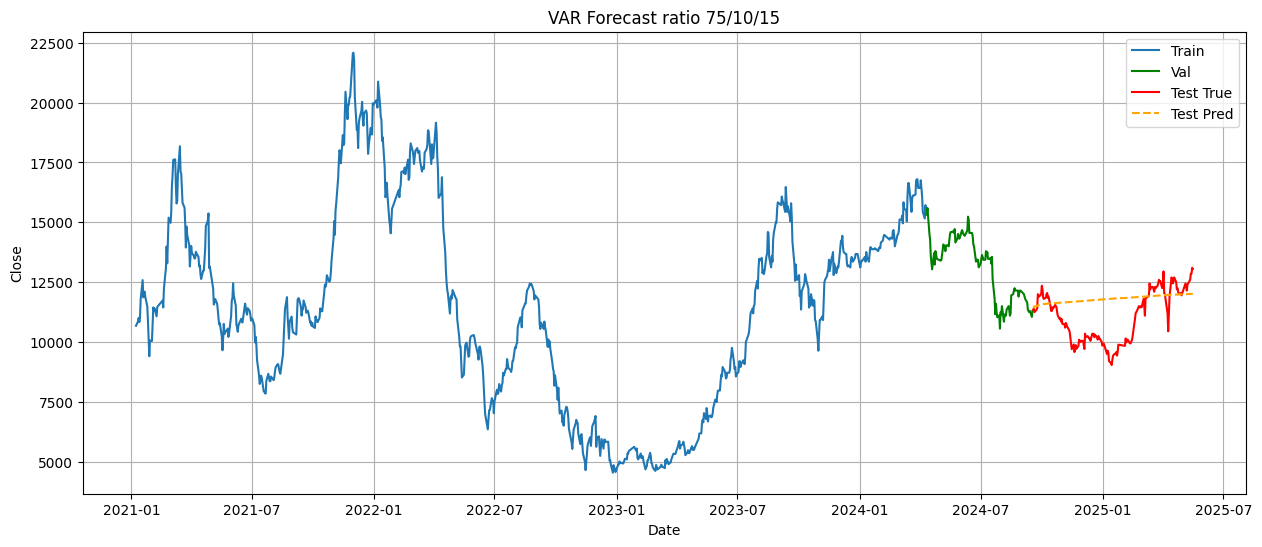

In [5]:
results_var_75, scaler_var_75 = train_evaluate_var(train_ratio=0.75, val_ratio=0.1, test_ratio=0.15)

* **70/10/20**

Tỷ lệ: Train 70% - Val 10% - Test 20%
→ Best lag (AIC): 4
→ Testing:
  MAE: 1397.44, MSE: 2777246.50, RMSE: 1666.51, MAPE: 13.23%, R²: -1.2127


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


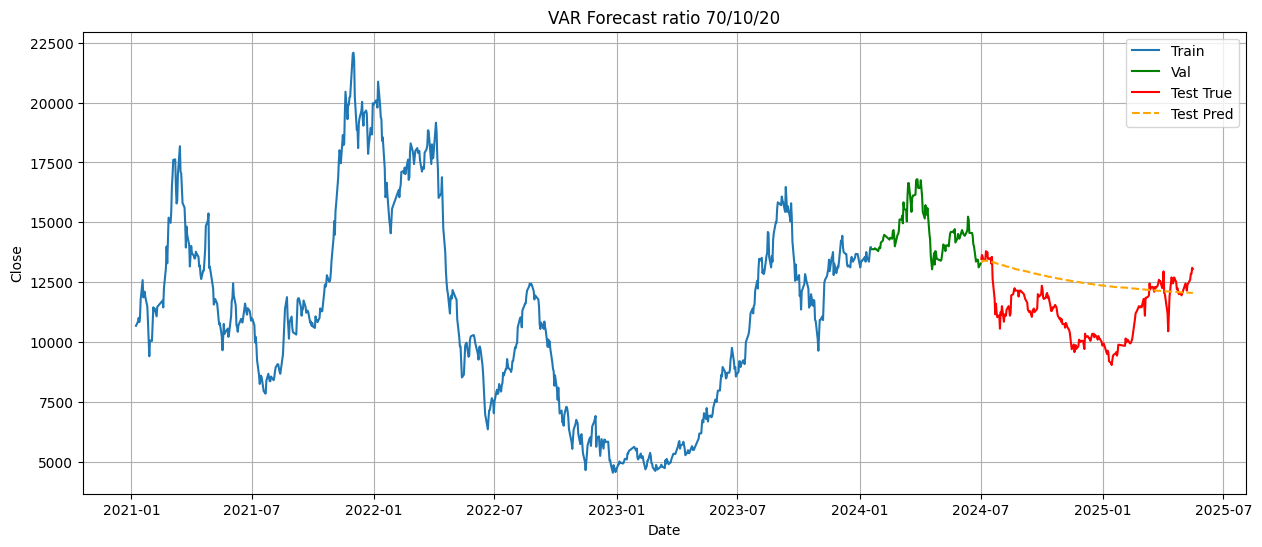

In [6]:
results_var_70, scaler_var_70 = train_evaluate_var(train_ratio=0.7, val_ratio=0.1, test_ratio=0.2)

* **65/10/25**

Tỷ lệ: Train 65% - Val 10% - Test 25%
→ Best lag (AIC): 6
→ Testing:
  MAE: 946.54, MSE: 1233433.18, RMSE: 1110.60, MAPE: 8.40%, R²: 0.4822


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


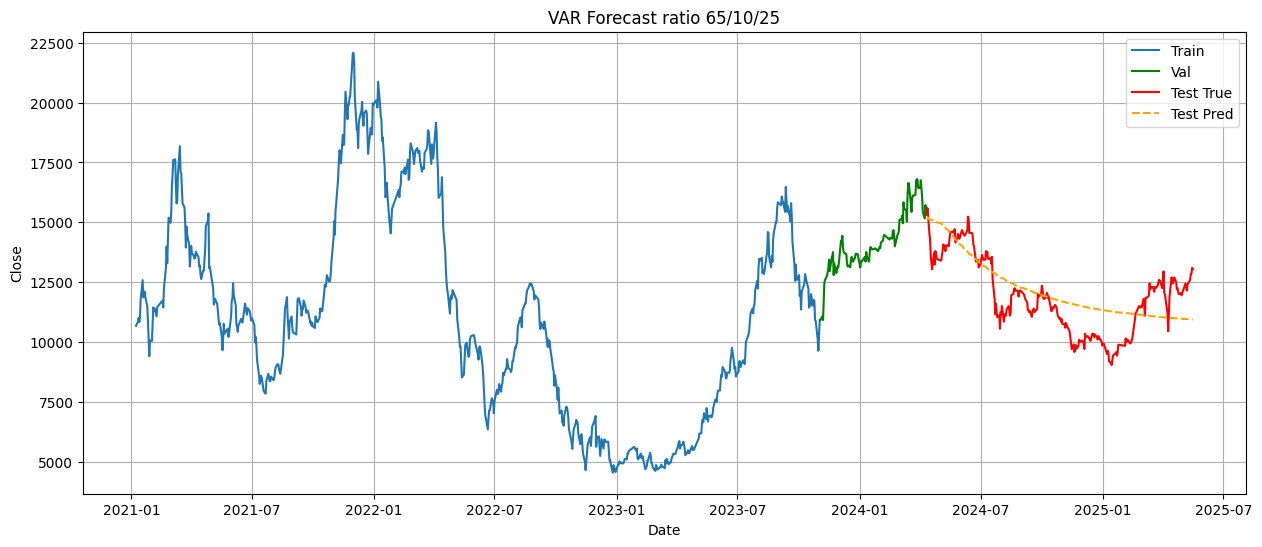

In [7]:
results_var_65, scaler_var_65 = train_evaluate_var(train_ratio=0.65, val_ratio=0.1, test_ratio=0.25)

# Dự đoán 30 ngày tiếp theo

In [8]:
def predict_next_30_days_var(model, scaler, df_scaled, df_original, target_col='Close'):
    """
    Dự báo và vẽ biểu đồ 30 ngày tiếp theo cho biến mục tiêu, chỉ hiển thị phần dự báo.
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    lag_order = model.k_ar
    input_data = df_scaled.values[-lag_order:]

    forecast = model.forecast(y=input_data, steps=30)
    forecast_df_scaled = pd.DataFrame(forecast, columns=df_scaled.columns)

    forecast_df = pd.DataFrame(
        scaler.inverse_transform(forecast_df_scaled),
        columns=df_scaled.columns
    )

    last_date = df_original.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='B')
    forecast_df.index = future_dates

    # Vẽ biểu đồ chỉ đoạn 30 ngày dự báo
    plt.figure(figsize=(12, 5))
    plt.plot(forecast_df.index, forecast_df[target_col], label='Predict 30 days', color='blue')
    plt.title("VIX stock price prediction for the next 30 days with VAR")
    plt.xlabel("Date")
    plt.ylabel("VIX stock close price")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return forecast_df[[target_col]]


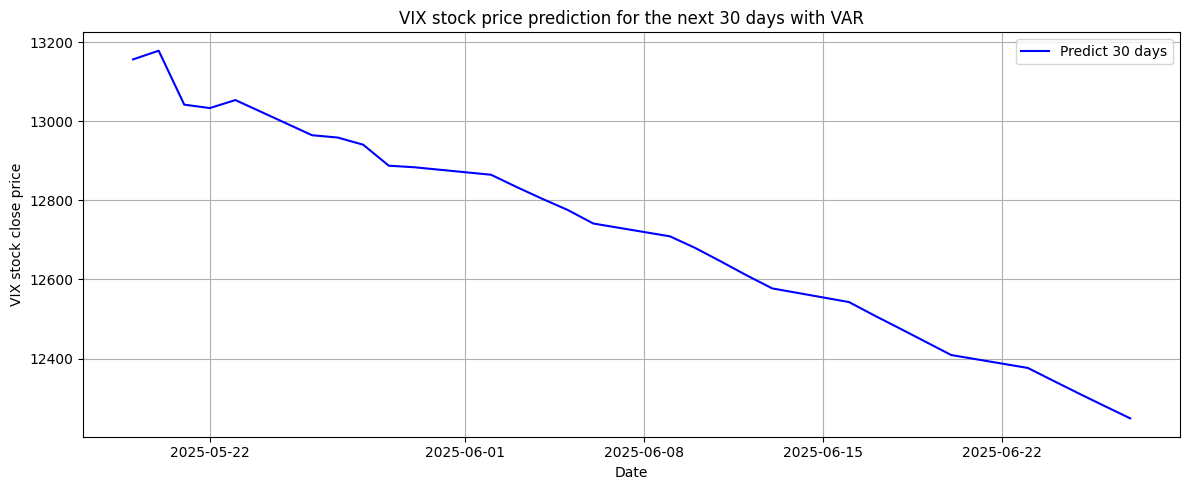

In [9]:
forecast_30d = predict_next_30_days_var(
    model=results_var_65,
    scaler=scaler_var_65,
    df_scaled=data_scaled,
    df_original=df,
    target_col='Close'
)


In [12]:
!jupyter nbconvert --to html "/content/drive/MyDrive/IS403/DoAnCuoiKy/Code/VAR/VAR.ipynb" --output-dir="/content/drive/MyDrive/IS403/DoAnCuoiKy/Code/VAR"

[NbConvertApp] Converting notebook /content/drive/MyDrive/IS403/DoAnCuoiKy/Code/VAR/VAR.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 697307 bytes to /content/drive/MyDrive/IS403/DoAnCuoiKy/Code/VAR/VAR.html
